# 1-3,文本数据建模流程范例

In [1]:
import os
import datetime

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from python_cgtools.utils_date import *
from python_cgtools.utils_torch import *

torch.__version__ =  2.0.1+cu118
torchvision.__version__ =  0.15.2+cu118
pytorch_lightning.__version__ =  2.0.2
torchtext.__version__ =  0.15.2
torchdata.__version__ =  0.6.1
torchmetrics.__version__ =  0.11.4
torchkeras.__version__ =  3.8.2
tensorflow sed random seed fail.


In [2]:
start_time = time.time()
print_with_time("start.........")

2023-05-27 12:43:09:start.........


In [3]:
# !pip install torchtext==0.11.0
# !pip install torchkeras==3.2.3

In [4]:
# torch.__version__ =  2.0.1+cu118
# torchtext.__version__ =  0.15.2
# torchkeras.__version__ =  3.8.2
import torch 
import torchtext 
import torchkeras 
print("torch.__version__ = ", torch.__version__)
print("torchtext.__version__ = ", torchtext.__version__) 
print("torchkeras.__version__ = ", torchkeras.__version__) 


torch.__version__ =  2.0.1+cu118
torchtext.__version__ =  0.15.2
torchkeras.__version__ =  3.8.2


```
torch.__version__ =  1.10.0
torchtext.__version__ =  0.11.0
torchkeras.__version__ =  3.2.3
```

<br>

<font color="red">
 
公众号 **算法美食屋** 回复关键词：**pytorch**， 获取本项目源码和所用数据集百度云盘下载链接。
    
</font> 


### 一，准备数据

imdb数据集的目标是根据电影评论的文本内容预测评论的情感标签。

训练集有20000条电影评论文本，测试集有5000条电影评论文本，其中正面评论和负面评论都各占一半。

文本数据预处理较为繁琐，包括文本切词，构建词典，编码转换，序列填充，构建数据管道等等。


在torch中预处理文本数据可以借助torchtext中的词典工具并自定义Dataset。

下面进行演示。


![](./data/电影评论.jpg)

In [5]:
import numpy as np 
import pandas as pd 
import torch 
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

MIN_FREQ = 30      #仅考虑词频超过30的词
MAX_LEN = 200      #每个样本保留200个词的长度
BATCH_SIZE = 20 


dftrain = pd.read_csv("./eat_pytorch_datasets/imdb/train.tsv",sep="\t",header = None,names = ["label","text"])
dfval = pd.read_csv("./eat_pytorch_datasets/imdb/test.tsv",sep="\t",header = None,names = ["label","text"])


#1，文本切词
tokenizer = get_tokenizer('basic_english')


In [6]:
dftrain

,label,text
0,0,It really boggles my mind when someone comes a...
1,0,Mary Pickford becomes the chieftain of a Scott...
2,0,"Well, at least my theater group did, lol. So o..."
3,1,I must give How She Move a near-perfect rating...
4,0,"I must say, when I read the storyline on the b..."
...,...,...
19995,1,"Simple, meaningful and delivers an emotional p..."
19996,1,"I'm fan of ART, I like anything about Art, I l..."
19997,0,Despite being a sequel to the more potent orig...
19998,0,"Also known in a different form as ""House of Ex..."


In [7]:
#2，构建词典
# PAD_IDX 用于填充因为句子补长带来的空缺，UNK_IDX用于表示不在字典中的 token
PAD_IDX,UNK_IDX = 0,1
special_symbols = ['<pad>','<unk>']

def yield_tokens(dfdata):
    for text in dfdata["text"]:
        yield tokenizer(text)
        

# specials 特殊标志，用于在字典中添加一些特殊的标记，比如下面用 <unk> 代表未存在的 token
# 注意这里只是将它们放入字典中，并没有其它的操作，相当于先在字典中占位
# special_first 表示是否将 specials 放在字典的最前面，默认为 True
vocab = build_vocab_from_iterator(
    yield_tokens(dftrain),
    min_freq = MIN_FREQ,
    specials=special_symbols,
    special_first=True)

# 设置默认索引，如果索引的单词不在词典内，则用 UNK_IDX，即 <unk> 代替
vocab.set_default_index(UNK_IDX)
vocab_size = len(vocab)
# vocab_size =8813
print("vocab_size ="+str(vocab_size)) 

#查看词典前20个词
#itos: index to string
#stoi: string to index
# vocab.get_itos():  ['<pad>', '<unk>', 'the', '.', ',', 'and', 'a', 'of', 'to', "'", 'is', 'it', 'in', 'i', 'this', 'that', 's', 'was', 'as', 'for']
# vocab.get_stoi()['<pad>']:  0
# vocab.get_stoi()['<unk>']:  1
print("vocab.get_itos(): ",vocab.get_itos()[:20])
print("vocab.get_stoi()['<pad>']: ",vocab.get_stoi()['<pad>'])
print("vocab.get_stoi()['<unk>']: ",vocab.get_stoi()['<unk>'])

vocab_size =8813
vocab.get_itos():  ['<pad>', '<unk>', 'the', '.', ',', 'and', 'a', 'of', 'to', "'", 'is', 'it', 'in', 'i', 'this', 'that', 's', 'was', 'as', 'for']
vocab.get_stoi()['<pad>']:  0
vocab.get_stoi()['<unk>']:  1


In [8]:
#3，序列填充
def pad(seq,max_length,pad_value=0):
    n = len(seq)
    result = seq+[pad_value]*max_length
    return result[:max_length]


#4，编码转换
def text_pipeline(text):
    words = tokenizer(text)
    tokens = vocab(words)
    result = pad(tokens,MAX_LEN,PAD_IDX)
    return result 

# 可以看到，填充 token 用的是 0，而未知 token 用的是 1
# [14, 10, 41, 461, 1, 36, 36, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
print(text_pipeline("this is an example aaaaaaa!!!"))

[14, 10, 41, 461, 1, 36, 36, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [9]:
#5，构建管道
from torch.utils.data import Dataset,DataLoader

class ImdbDataset(Dataset):
    def __init__(self,df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self,index):
        text = self.df["text"].iloc[index]
        label = torch.tensor([self.df["label"].iloc[index]]).float()
        tokens = torch.tensor(text_pipeline(text)).int() 
        return tokens,label
    
ds_train = ImdbDataset(dftrain)
ds_val = ImdbDataset(dfval)


In [10]:
# (tensor([  11,   72,    1,   64,  349,   61,  278,  269,  629,    6,   21,   45,
#            14,    5, 2383,   11,    8,   34,   35,    7,    2,  252, 1213,  113,
#            53,   46,    3,   14,   10,   40,  241,   29,   35,    7,    2,  252,
#            53,   46,    4,  138,   29,    6,   58,   21,    4,   22,   29,    2,
#           252, 2887,    3,  149,   75,  150,   45,  344, 3951,   48,  536, 2068,
#             5,  101,  220,  153,    8,   76,    5,  373,   76,   52,   26,  110,
#             2,  324,  922, 1184,   10,    2,  252,    3,    2,   23,   51,  550,
#           395,  171,    5,  776,    4,   69,   10,  104,   59,   79,   13,   57,
#           140,   19,  115,   59,  560, 3844, 1213,  113,    3,    2,   23,  159,
#             9,   27, 1593,   28,    2, 4427, 2344,    4,   46,    9,   16,   35,
#           344,  119,   26,   75,   31,    1,  218, 2852,   90,    6, 3377,    4,
#            22,   38,   87, 2344,   32,  944,  227,    3,   22,    2,  579,    7,
#          4427, 2087,  564,  159,    9,   27,  381,   14,  213,    9,   27,    6,
#          1213,   23,    4,   49,    6,   89,   35,    3,    2,   23,   17,  530,
#          1410,   29,    8,   34,  613,  105,  594,    3,    2,   23,  384,   12,
#            37,    2,  137,    7,    2,  341, 1213, 6785,    4,   44,   11,  430,
#            17,    6, 5282,   28, 2073, 1213,  775,    4], dtype=torch.int32),
#  tensor([0.]))
ds_train[0]

(tensor([  11,   72,    1,   64,  349,   61,  278,  269,  629,    6,   21,   45,
           14,    5, 2383,   11,    8,   34,   35,    7,    2,  252, 1213,  113,
           53,   46,    3,   14,   10,   40,  241,   29,   35,    7,    2,  252,
           53,   46,    4,  138,   29,    6,   58,   21,    4,   22,   29,    2,
          252, 2887,    3,  149,   75,  150,   45,  344, 3951,   48,  536, 2068,
            5,  101,  220,  153,    8,   76,    5,  373,   76,   52,   26,  110,
            2,  324,  922, 1184,   10,    2,  252,    3,    2,   23,   51,  550,
          395,  171,    5,  776,    4,   69,   10,  104,   59,   79,   13,   57,
          140,   19,  115,   59,  560, 3844, 1213,  113,    3,    2,   23,  159,
            9,   27, 1593,   28,    2, 4427, 2344,    4,   46,    9,   16,   35,
          344,  119,   26,   75,   31,    1,  218, 2852,   90,    6, 3377,    4,
           22,   38,   87, 2344,   32,  944,  227,    3,   22,    2,  579,    7,
         4427, 2087,  564,  

In [11]:
dl_train = DataLoader(ds_train,batch_size = 50,shuffle = True, collate_fn=cuda_collate_fn)
dl_val = DataLoader(ds_val,batch_size = 50,shuffle = False, collate_fn=cuda_collate_fn)

In [12]:
for features,labels in dl_train:
    print(features,labels)
    break

tensor([[   7,   38,    2,  ...,    0,    0,    0],
        [1235,   11,   17,  ...,    0,    0,    0],
        [ 635, 1239,  183,  ...,   11,  430,  170],
        ...,
        [ 157, 2738, 2385,  ...,    0,    0,    0],
        [ 473,   13,   33,  ...,    2, 6500,  853],
        [  13, 1674,  106,  ...,    1,    4, 7912]], device='cuda:0',
       dtype=torch.int32) tensor([[1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
 

### 二，定义模型

使用Pytorch通常有三种方式构建模型：使用nn.Sequential按层顺序构建模型，继承nn.Module基类构建自定义模型，继承nn.Module基类构建模型并辅助应用模型容器(nn.Sequential,nn.ModuleList,nn.ModuleDict)进行封装。

此处选择使用第三种方式进行构建。


In [13]:
import torch
from torch import nn 

In [14]:
# 6244 怎么来的
# 第一层卷积：200 - 5 + 1 = 196
# 最大池化： 196 // 2 = 98
# 第二层卷积：98 - 2 + 1 = 97
# 最大池化：97 // 2 = 48
# flatten: 48 * 通道数 128 = 6144

In [15]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        #设置padding_idx参数后将在训练过程中将填充的token始终赋值为0向量
        # 每个句子的长度并不一定是等长的, 这时候就需要对较短的句子进行padding, nn.Embedding中padding_idx是指定padding的索引值
        # padding_idx 指定为 0，与上面的 PAD_IDX 一致，这样填充的 pad 的 embedding 都是 0
        self.embedding = nn.Embedding(num_embeddings = vocab_size,embedding_dim = 3,padding_idx = 0)
        
        # 利用 add_module 可以使得更模块化更清晰
        self.conv = nn.Sequential()
        self.conv.add_module("conv_1",nn.Conv1d(in_channels = 3,out_channels = 16,kernel_size = 5))
        self.conv.add_module("pool_1",nn.MaxPool1d(kernel_size = 2))
        self.conv.add_module("relu_1",nn.ReLU())
        self.conv.add_module("conv_2",nn.Conv1d(in_channels = 16,out_channels = 128,kernel_size = 2))
        self.conv.add_module("pool_2",nn.MaxPool1d(kernel_size = 2))
        self.conv.add_module("relu_2",nn.ReLU())
        
        self.dense = nn.Sequential()
        self.dense.add_module("flatten",nn.Flatten())
        self.dense.add_module("linear",nn.Linear(6144,1))
        
        
    def forward(self,x):
        x = self.embedding(x).transpose(1,2)
        x = self.conv(x)
        y = self.dense(x)
        return y

# 可以看到分成了 embedding, conv, dense 三个子模块
net = Net()
net = net.to(device)
print(net)

Net(
  (embedding): Embedding(8813, 3, padding_idx=0)
  (conv): Sequential(
    (conv_1): Conv1d(3, 16, kernel_size=(5,), stride=(1,))
    (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_1): ReLU()
    (conv_2): Conv1d(16, 128, kernel_size=(2,), stride=(1,))
    (pool_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_2): ReLU()
  )
  (dense): Sequential(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=6144, out_features=1, bias=True)
  )
)


```
Net(
  (embedding): Embedding(8813, 3, padding_idx=0)
  (conv): Sequential(
    (conv_1): Conv1d(3, 16, kernel_size=(5,), stride=(1,))
    (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_1): ReLU()
    (conv_2): Conv1d(16, 128, kernel_size=(2,), stride=(1,))
    (pool_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_2): ReLU()
  )
  (dense): Sequential(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=6144, out_features=1, bias=True)
  )
)
```

In [16]:
# 可以看到 0 索引对应的初始值都是 0
net.embedding.weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000],
        [-0.2434, -0.0553, -0.3519],
        [ 0.2157,  0.7259, -0.0895],
        ...,
        [ 0.1295, -2.2546, -0.7860],
        [ 0.5400, -0.5162, -0.6622],
        [ 2.6781,  1.7091, -0.3050]], device='cuda:0', requires_grad=True)

In [17]:
# Layer (type)                            Output Shape              Param #
# ==========================================================================
# Embedding-1                             [-1, 200, 3]               26,439
# Conv1d-2                               [-1, 16, 196]                  256
# MaxPool1d-3                             [-1, 16, 98]                    0
# ReLU-4                                  [-1, 16, 98]                    0
# Conv1d-5                               [-1, 128, 97]                4,224
# MaxPool1d-6                            [-1, 128, 48]                    0
# ReLU-7                                 [-1, 128, 48]                    0
# Flatten-8                                 [-1, 6144]                    0
# Linear-9                                     [-1, 1]                6,145
# ==========================================================================
# Total params: 37,064
# Trainable params: 37,064
# Non-trainable params: 0
# --------------------------------------------------------------------------
# Input size (MB): 0.000069
# Forward/backward pass size (MB): 0.287788
# Params size (MB): 0.141388
# Estimated Total Size (MB): 0.429245
# --------------------------------------------------------------------------
from torchkeras import summary 
summary(net,input_data=features);


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Embedding-1                             [-1, 200, 3]               26,439
Conv1d-2                               [-1, 16, 196]                  256
MaxPool1d-3                             [-1, 16, 98]                    0
ReLU-4                                  [-1, 16, 98]                    0
Conv1d-5                               [-1, 128, 97]                4,224
MaxPool1d-6                            [-1, 128, 48]                    0
ReLU-7                                 [-1, 128, 48]                    0
Flatten-8                                 [-1, 6144]                    0
Linear-9                                     [-1, 1]                6,145
Total params: 37,064
Trainable params: 37,064
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.000069
Forward/backwa

### 三，训练模型

训练Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。

此处介绍一种较通用的仿照Keras风格的类形式的训练循环。

该训练循环的代码也是torchkeras库的核心代码。

torchkeras详情:  https://github.com/lyhue1991/torchkeras 



In [18]:
import os,sys,time
import numpy as np
import pandas as pd
import datetime 
from tqdm import tqdm 

import torch
from torch import nn 
from copy import deepcopy

def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(str(info)+"\n")

class StepRunner:
    def __init__(self, net, loss_fn,stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
    
    def __call__(self, features, labels):
        #loss
        preds = self.net(features)
        loss = self.loss_fn(preds,labels)

        #backward()
        if self.optimizer is not None and self.stage=="train":
            loss.backward()
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        #metrics
        step_metrics = {self.stage+"_"+name:metric_fn(preds, labels).item() 
                        for name,metric_fn in self.metrics_dict.items()}
        return loss.item(),step_metrics


class EpochRunner:
    def __init__(self,steprunner):
        self.steprunner = steprunner
        self.stage = steprunner.stage
        self.steprunner.net.train() if self.stage=="train" else self.steprunner.net.eval()
        
    def __call__(self,dataloader):
        total_loss,step = 0,0
        loop = tqdm(enumerate(dataloader), total =len(dataloader))
        for i, batch in loop: 
            if self.stage=="train":
                loss, step_metrics = self.steprunner(*batch)
            else:
                with torch.no_grad():
                    loss, step_metrics = self.steprunner(*batch)
            step_log = dict({self.stage+"_loss":loss},**step_metrics)

            total_loss += loss
            step+=1
            if i!=len(dataloader)-1:
                loop.set_postfix(**step_log)
            else:
                epoch_loss = total_loss/step
                epoch_metrics = {self.stage+"_"+name:metric_fn.compute().item() 
                                 for name,metric_fn in self.steprunner.metrics_dict.items()}
                epoch_log = dict({self.stage+"_loss":epoch_loss},**epoch_metrics)
                loop.set_postfix(**epoch_log)

                for name,metric_fn in self.steprunner.metrics_dict.items():
                    metric_fn.reset()
        return epoch_log

class KerasModel(torch.nn.Module):
    def __init__(self,net,loss_fn,metrics_dict=None,optimizer=None,lr_scheduler = None):
        super().__init__()
        self.history = {}
        
        self.net = net
        self.loss_fn = loss_fn
        self.metrics_dict = nn.ModuleDict(metrics_dict) 
        
        self.optimizer = optimizer if optimizer is not None else torch.optim.Adam(
            self.parameters(), lr=1e-2)
        self.lr_scheduler = lr_scheduler

    def forward(self, x):
        if self.net:
            return self.net.forward(x)
        else:
            raise NotImplementedError


    def fit(self, train_data, val_data=None, epochs=10, ckpt_path='checkpoint.pt', 
            patience=5, monitor="val_loss", mode="min"):

        for epoch in range(1, epochs+1):
            printlog("Epoch {0} / {1}".format(epoch, epochs))
            
            # 1，train -------------------------------------------------  
            train_step_runner = StepRunner(net = self.net,stage="train",
                    loss_fn = self.loss_fn,metrics_dict=deepcopy(self.metrics_dict),
                    optimizer = self.optimizer, lr_scheduler = self.lr_scheduler)
            train_epoch_runner = EpochRunner(train_step_runner)
            train_metrics = train_epoch_runner(train_data)
            
            for name, metric in train_metrics.items():
                self.history[name] = self.history.get(name, []) + [metric]

            # 2，validate -------------------------------------------------
            if val_data:
                val_step_runner = StepRunner(net = self.net,stage="val",
                    loss_fn = self.loss_fn,metrics_dict=deepcopy(self.metrics_dict))
                val_epoch_runner = EpochRunner(val_step_runner)
                with torch.no_grad():
                    val_metrics = val_epoch_runner(val_data)
                val_metrics["epoch"] = epoch
                for name, metric in val_metrics.items():
                    self.history[name] = self.history.get(name, []) + [metric]
            
            # 3，early-stopping -------------------------------------------------
            if not val_data:
                continue
            arr_scores = self.history[monitor]
            best_score_idx = np.argmax(arr_scores) if mode=="max" else np.argmin(arr_scores)
            if best_score_idx==len(arr_scores)-1:
                torch.save(self.net.state_dict(),ckpt_path)
                print("<<<<<< reach best {0} : {1} >>>>>>".format(monitor,
                     arr_scores[best_score_idx]),file=sys.stderr)
            if len(arr_scores)-best_score_idx>patience:
                print("<<<<<< {} without improvement in {} epoch, early stopping >>>>>>".format(
                    monitor,patience),file=sys.stderr)
                break 
                
        self.net.load_state_dict(torch.load(ckpt_path))  
        return pd.DataFrame(self.history)

    @torch.no_grad()
    def evaluate(self, val_data):
        val_step_runner = StepRunner(net = self.net,stage="val",
                    loss_fn = self.loss_fn,metrics_dict=deepcopy(self.metrics_dict))
        val_epoch_runner = EpochRunner(val_step_runner)
        val_metrics = val_epoch_runner(val_data)
        return val_metrics
        
       
    @torch.no_grad()
    def predict(self, dataloader):
        self.net.eval()
        result = torch.cat([self.forward(t[0]) for t in dataloader])
        return result.data


In [19]:
import torchmetrics 

class Accuracy(torchmetrics.Accuracy):
    def __init__(self, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        
    def update(self, preds: torch.Tensor, targets: torch.Tensor):
        super().update(torch.sigmoid(preds),targets.long())
            
    def compute(self):
        return super().compute()
    
net = Net()
net = net.to(device)
model = KerasModel(net,
                  loss_fn = nn.BCEWithLogitsLoss(),
                  optimizer= torch.optim.Adam(net.parameters(),lr = 0.01),  
                  metrics_dict = {"acc":Accuracy(task="binary").to(device)}
                )


In [20]:
model.fit(dl_train,
    val_data=dl_val,
    epochs=10,
    ckpt_path='checkpoint.pt',
    patience=5,
    monitor='val_acc',
    mode='max')


================================================================================2023-05-27 12:43:13
Epoch 1 / 10



100%|█████████████████████████████████████████████████| 100/100 [00:01<00:00, 78.58it/s, val_acc=0.512, val_loss=0.693]
<<<<<< reach best val_acc : 0.5123999714851379 >>>>>>



================================================================================2023-05-27 12:43:21
Epoch 2 / 10



100%|█████████████████████████████████████████████████| 100/100 [00:01<00:00, 80.73it/s, val_acc=0.515, val_loss=0.693]
<<<<<< reach best val_acc : 0.5145999789237976 >>>>>>



================================================================================2023-05-27 12:43:28
Epoch 3 / 10



100%|█████████████████████████████████████████████████| 100/100 [00:01<00:00, 79.39it/s, val_acc=0.512, val_loss=0.694]



================================================================================2023-05-27 12:43:35
Epoch 4 / 10



100%|█████████████████████████████████████████████████| 100/100 [00:01<00:00, 78.79it/s, val_acc=0.509, val_loss=0.694]



================================================================================2023-05-27 12:43:43
Epoch 5 / 10



100%|██████████████████████████████████████████████████| 100/100 [00:01<00:00, 77.56it/s, val_acc=0.669, val_loss=0.62]
<<<<<< reach best val_acc : 0.6686000227928162 >>>>>>



================================================================================2023-05-27 12:43:50
Epoch 6 / 10



100%|█████████████████████████████████████████████████| 100/100 [00:01<00:00, 81.19it/s, val_acc=0.775, val_loss=0.474]
<<<<<< reach best val_acc : 0.7752000093460083 >>>>>>



================================================================================2023-05-27 12:43:58
Epoch 7 / 10



100%|█████████████████████████████████████████████████| 100/100 [00:01<00:00, 79.45it/s, val_acc=0.806, val_loss=0.426]
<<<<<< reach best val_acc : 0.8064000010490417 >>>>>>



================================================================================2023-05-27 12:44:05
Epoch 8 / 10



100%|█████████████████████████████████████████████████| 100/100 [00:01<00:00, 80.76it/s, val_acc=0.805, val_loss=0.434]



================================================================================2023-05-27 12:44:12
Epoch 9 / 10



100%|█████████████████████████████████████████████████| 100/100 [00:01<00:00, 80.15it/s, val_acc=0.809, val_loss=0.449]
<<<<<< reach best val_acc : 0.8086000084877014 >>>>>>



================================================================================2023-05-27 12:44:19
Epoch 10 / 10



100%|█████████████████████████████████████████████████| 100/100 [00:01<00:00, 81.30it/s, val_acc=0.805, val_loss=0.479]


,train_loss,train_acc,val_loss,val_acc,epoch
0,0.700175,0.51020,0.692903,0.5124,1
1,0.693608,0.50155,0.693044,0.5146,2
2,0.693390,0.49675,0.694017,0.5124,3
3,0.693450,0.50205,0.694071,0.5094,4
4,0.687925,0.51930,0.619832,0.6686,5
5,0.524066,0.74385,0.473903,0.7752,6
6,0.413272,0.81645,0.425900,0.8064,7
7,0.347079,0.85310,0.433706,0.8048,8
8,0.302009,0.87795,0.449080,0.8086,9
9,0.262647,0.89695,0.479382,0.8048,10


In [21]:
# 如果设置的全0，即使 requires_grad=True，在计算梯度的时候也是0，因此最终还是0，这也符合 占位 token 的定义，并不会影响结果
net.embedding.weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000],
        [-0.3076, -0.5088, -0.4640],
        [-0.5594, -0.6285,  0.2777],
        ...,
        [ 1.1531, -1.4187, -0.5329],
        [-0.3310,  0.6910, -1.5760],
        [ 0.7521,  0.0942, -0.2625]], device='cuda:0', requires_grad=True)

### 四，评估模型

In [22]:
import pandas as pd 

history = model.history
dfhistory = pd.DataFrame(history) 
dfhistory 


,train_loss,train_acc,val_loss,val_acc,epoch
0,0.700175,0.51020,0.692903,0.5124,1
1,0.693608,0.50155,0.693044,0.5146,2
2,0.693390,0.49675,0.694017,0.5124,3
3,0.693450,0.50205,0.694071,0.5094,4
4,0.687925,0.51930,0.619832,0.6686,5
5,0.524066,0.74385,0.473903,0.7752,6
6,0.413272,0.81645,0.425900,0.8064,7
7,0.347079,0.85310,0.433706,0.8048,8
8,0.302009,0.87795,0.449080,0.8086,9
9,0.262647,0.89695,0.479382,0.8048,10


In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory["train_"+metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
    

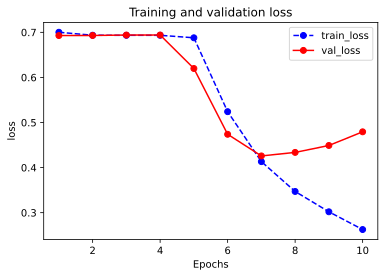

In [24]:
plot_metric(dfhistory,"loss")

![](./data/1-3-loss曲线.png)

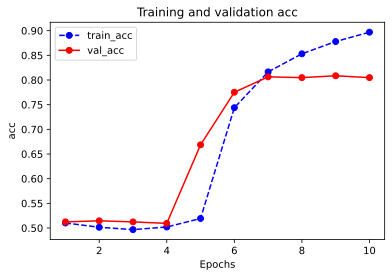

In [25]:
plot_metric(dfhistory,"acc")

![](./data/1-3-accuracy曲线.png)

In [26]:
# 评估
# {'val_loss': 0.44908038392663, 'val_acc': 0.8086000084877014}
model.evaluate(dl_val)

100%|█████████████████████████████████████████████████| 100/100 [00:01<00:00, 79.64it/s, val_acc=0.809, val_loss=0.449]


{'val_loss': 0.44908038392663, 'val_acc': 0.8086000084877014}

```
{'val_loss': 0.36953783154487607, 'val_acc': 0.848800003528595}
```

### 五，使用模型

In [27]:
def predict(net,dl):
    net.eval()
    with torch.no_grad():
        result = nn.Sigmoid()(torch.cat([net.forward(t[0]) for t in dl]))
    return(result.data)


In [28]:
# tensor([[0.9281],
#         [0.6684],
#         [0.9579],
#         ...,
#         [0.8942],
#         [0.2010],
#         [0.9637]], device='cuda:0')
y_pred_probs = predict(net,dl_val)
y_pred_probs

tensor([[0.9281],
        [0.6684],
        [0.9579],
        ...,
        [0.8942],
        [0.2010],
        [0.9637]], device='cuda:0')

```
tensor([[0.5638],
        [0.9990],
        [0.9573],
        ...,
        [0.9188],
        [0.8004],
        [0.9998]])
```

In [29]:
assert (torch.sigmoid(model.predict(dl_val)) == y_pred_probs).all()

In [30]:
# tensor([[0.9637]], device='cuda:0', grad_fn=<SigmoidBackward0>)
torch.sigmoid(net.forward(torch.tensor([text_pipeline("this movie is wonderful")]).to(device)))
# predict(net,[(torch.tensor([text_pipeline("this movie is wonderful")]), 1)])

tensor([[0.9637]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [31]:
# 可以看到，即使 加了 not 并没有改变预测值，这可能是卷积网络 + 最大池化导致的
# tensor([[0.9637]], device='cuda:0', grad_fn=<SigmoidBackward0>)
torch.sigmoid(net.forward(torch.tensor([text_pipeline("this movie is not wonderful")]).to(device)))

tensor([[0.9637]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [32]:
# tensor([[0.6981]], device='cuda:0', grad_fn=<SigmoidBackward0>)
torch.sigmoid(net.forward(torch.tensor([text_pipeline("this movie is boring")]).to(device)))

tensor([[0.6981]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [33]:
# cpu: 2023-05-27 11:28:55:spent 1.0 分27.136 秒
# gpu: 2023-05-27 11:53:08:spent 1.0 分24.176 秒
# pin_memory=True, 2023-05-27 01:08:44:spent 1.0 分18.778 秒，并没有变好
end_time = time.time()
print_with_time("spent {}".format(get_time_interval_str(end_time - start_time)))

2023-05-27 12:44:30:spent 1.0 分21.248 秒


**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)